# **Compensador dinâmico**

Já aprendemos a projetar um regulador, que é um conjunto de ganhos que calcula a ação de controle usando os estados do sistema.

Também aprendemos a projetar um observador de estados, que é um sistema dinâmico cuja função é fornecer uma estimativa dos estados reais do sistema a partir do sinal de saída.

O compensador dinâmico é a junção destas duas ideias no mesmo sistema.

A Figura abaixo esquematiza todos os subsistemas e rotas de sinal com a estratégia adotada.
<p>
<img src="Fig7.35.svg" width="80%">
</p>

No final, nosso controlador projetado com essas abordagens é um único sistema, cujas equações de estado são:


$$ 
\begin{align*}
    \dot{\mathbf{\hat{x}}} &= \mathbf{(A-BK-LC)}\mathbf{\hat{x}}+\mathbf{L}y\\
    u &= \mathbf{-K}\mathbf{\hat{x}}
\end{align*}
$$

onde $\mathbf{x}_e$ é a estimativa dos estados do sistema pelo observador, $\mathbf{K}$ e $\mathbf{L}$ são respectivamente os ganhos do regulador e do observador. Note que a entrada do controlador é a saída da planta. Da mesma forma, o sinal de saída do controlador é o sinal de controle $u$, que vai para a entrada da planta. 

Perceba, que estas duas equações permitem realizar o controlador como um sistema entrada-saída normal, com uma função de transferência que basicamente dispensa as equações de estado, para fins de implementação. Esta função é:

$$ 
\begin{align*}
    C(s) &= -\mathbf{K}(s\mathbf{I-A+BK+LC})^{-1}\mathbf{L}
\end{align*}
$$


## Simulação em malha fechada

O sistema completo (planta+controlador) pode ser simulados usando um único conjunto de equações de estados:

$$
\begin{align*}
\dot{\mathbf{x}} &= \mathbf{A}\mathbf{x}-\mathbf{BK}\mathbf{\hat{x}}\\
\dot{\mathbf{\hat{x}}} &= \mathbf{(A-BK-LC)}\mathbf{\hat{x}}+\mathbf{LCx}\\
y&= \mathbf{Cx}
\end{align*}
$$

É possível demonstrar que o polinômio de malha fechada quando usamos um compensador é:
$$
\begin{align*}
    \alpha_{\text{mf}}(s) = \alpha_{\text{reg}}(s)\cdot \alpha_{\text{obs}}(s)
\end{align*}
$$
onde "mf", "reg" e "obs" indicam respectivamente "malha fechada", "regulador" e "observador".

Observe que, desta forma, o conjunto de pólos de MF é a união dos pólos do OBS com os pólos do REG, o que permite que os projetos do observador e do regulador sejam feitos de forma independente. Isso é chamado de principío da separação em teoria de controle. 

## Implementação quando o observador é reduzido

Quando o observador usado é de ordem reduzida, as equações de estado do controlador sofrem algumas mudanças, para acomodar a suposição que um dos estados é medido e o particionamento de matrizes. 

A função de transferência com o observador reduzido é:

$$
\begin{align*}
C(s) &= \mathbf{C}_r(s\mathbf{I}-\mathbf{A}_r)^{-1}\mathbf{B}_r+D_r
\end{align*}
$$

onde:

$$
\begin{align*}
\mathbf{A}_r &= \mathbf{A}_{bb}-\mathbf{LA}_{ab}-(\mathbf{B}_{b}-\mathbf{LB}_{a})\mathbf{K}_b\\
\mathbf{B}_r &= \mathbf{A}_{r}\mathbf{L}+\mathbf{A}_{ba}-\mathbf{L}\mathbf{A}_{aa}-(\mathbf{B}_{b}-\mathbf{LB}_{a}){K}_a\\
\mathbf{C}_r &= -\mathbf{K}_b\\
D_r &= -K_a-\mathbf{K}_b\mathbf{L}
\end{align*}
$$


No caso, as matrizes $\mathbf{A}_{aa}$, $\mathbf{A}_{ab}$, $\mathbf{A}_{ba}$, $\mathbf{B}_{a}$ e $\mathbf{B}_{b}$ são provenientes do particionamento das matrizes do sistema, conforme o projeto do observador reduzido. 

A matriz $\mathbf{K}_{b}$ e o ganho ${K}_{a}$ são provenientes do particionamento do vetor de ganhos do regulador. O ganho $K_a$ é o ganho associado ao estado diretamente medido (i.e. a saída) e $\mathbf{K}_{b}$ é o restante do vetor projetado. 

<p align="center">
<img src="Ex7.28.svg" width="80%">
</p>

Vamos resolver usando as funções diretas de alocação de polos

In [1]:
# Imports
import numpy as np
import control as ct
from escrever import *
from IPython.display import display, Math
esc = escrever()

In [2]:
# Declara o sistema
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
D = np.array([[0]])
esc.sist(A,B,C,D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
# Aloca os polos do regulador
pr = -0.707+0.707j
K = ct.acker(A,B,[pr,np.conj(pr)])
display(Math(r'\mathbf{K} = ' + esc.mat(K.round(decimals=4))))

<IPython.core.display.Math object>

No livro os ganhos são $1$ e $\sqrt{2}$ exatamente. Você pode conferir com o Python que os resultados decimais estão bem próximos.

In [4]:
# Projeto do observador
wn = 5
xi = 0.5
po = -xi*wn+1j*wn*np.sqrt(1-xi**2)
L = ct.acker(A.T, C.T, [po,np.conj(po)]).T
display(Math(r'\mathbf{L} = ' + esc.mat(L.round(4))))

<IPython.core.display.Math object>

In [5]:
# Compensador no espaço de estados
Acomp = A-B@K-L@C
Bcomp = L
Ccomp = -K
Dcomp = np.array([[0]])
Comp = ct.ss(Acomp,Bcomp,Ccomp,Dcomp)
esc.sist(Acomp.round(4),Bcomp.round(4),Ccomp.round(4),Dcomp)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# Função de transf. do compensador
ct.tf(Comp)

TransferFunction(array([-40.34849, -24.99245]), array([ 1.      ,  6.414   , 33.069698]))

<p align="center">
<img src="Ex7.30.svg" width="80%">
</p>

In [7]:
# Expande o numerador para achar os coeficientes
den = np.poly([0,-2,-8])
print(den)

[ 1. 10. 16.  0.]


In [8]:
# Assim, as matrizes serão:
A = np.array([[-10,1,0],[-16,0,1],[0,0,0]])
B = np.array([[0],[0],[10]])
C = np.array([[1,0,0]])
D = np.array([[0]])

sys = ct.ss(A,B,C,D)
esc.sist(A,B,C,D)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
# Posicionamento de polos
pc = [-1.42, -1.04+2.14j,-1.04-2.14j]
pe = [-4.25, -3.13+6.41j,-3.13-6.41j]

K = ct.acker(A,B,pc)
L = ct.acker(A.T,C.T,pe).T

display(Math(r'\mathbf{K} = ' + esc.mat(K.round(4))))
display(Math(r'\mathbf{L} = ' + esc.mat(L.round(4))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# Montagem do controlador e função de transferência
Ac = A-B@K-L@C
Bc = L
Cc = -K
Dc = np.zeros((1,1))

comp = ct.ss(Ac,Bc,Cc,0)
esc.sist(Ac.round(4),Bc.round(4),Cc.round(4),Dc)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Função de transf.
ct.tf(comp)

TransferFunction(array([-190.0340288 , -482.20028555, -173.85034277]), array([   1.      ,    4.01    ,   66.7898  , -146.001298]))

In [12]:
# Pólos e zeros em MF
tab=ct.damp(comp)
print("Zeros:")
print(ct.zeros(comp))

_____Eigenvalue______ Damping___ Frequency_
    -2.943    +8.317j     0.3336      8.822
    -2.943    -8.317j     0.3336      8.822
     1.876                     1     -1.876
Zeros:
[-0.43516541+0.j -2.10227638+0.j]


In [13]:
# Analisa o sistema em malha fechada
Amf = np.block([[A,-B@K],[L@C,A-B@K-L@C]])
Bmf = np.zeros((2*B.size,1))
Cmf = np.block([C,np.zeros((C.shape))])
Dmf = np.zeros((Cmf.shape[0],Bmf.shape[1]))
MF = ct.ss(Amf,Bmf,Cmf,Dmf)
esc.sist(Amf.round(4),Bmf.round(4),Cmf.round(4),Dmf)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
# Relatório de polos
tab=ct.damp(MF)

_____Eigenvalue______ Damping___ Frequency_
     -3.13     +6.41j     0.4388      7.133
     -3.13     -6.41j     0.4388      7.133
     -4.25                     1       4.25
     -1.04     +2.14j     0.4371      2.379
     -1.04     -2.14j     0.4371      2.379
     -1.42                     1       1.42


In [46]:
# Simulação de estado inicial
x0 = np.random.random(size=(Amf.shape[0],1))
resp = ct.initial_response(MF,5,x0)

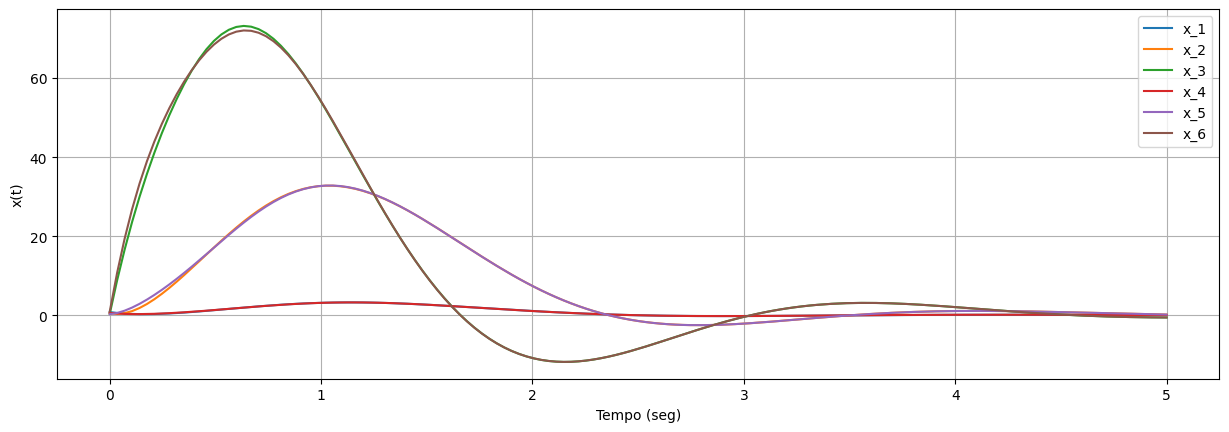

In [47]:
from matplotlib import pyplot as plt
plt.figure().set_figwidth(15)
plt.plot(resp.t, resp.x.T)
plt.grid()
plt.xlabel('Tempo (seg)')
plt.ylabel('x(t)')
plt.legend(['x_'+f'{i+1}' for i in range(7)])
plt.show()